## ЛАБОРАТОРНАЯ РАБОТА ИТОГОВАЯ
## Статистическая обработка данных психологического исследования
#### по дисциплине «Математическая статистика»
Направление подготовки 01.03.02 Прикладная математика и информатика
Очной формы обучения

выполнил: студент группы Б9123-01.03.02ии

Иванов Матвей Олегович

принял: Деревягин Андрей Алексеевич

# Математическая часть

### Тест Шапиро-Уилка
Тест Шапиро-Уилка — это проверка гипотез, которая применяется к выборке данных с нулевой
гипотезой о том, что выборка имеет нормальное распределение.
- $H_0: X \sim N (\mu_x, \sigma^2_x), Y \sim N (\mu_x, \sigma^2_x)$
- $H_1: X \cancel{\sim} N (\mu_x, \sigma^2_x), Y \cancel{\sim} N (\mu_x, \sigma^2_x)$

### Критерий Колмогорова-Смирнова

Критерий Колмогорова-Смирнова - Проверка, что выборка из нормального распределения
- $H_0: F_x=N, F_y=N$
- $H_1: F_x \ne N, F_y \ne N$


### T критерий

- $H_0: \mu_x = \mu_y$
- $H_1: \mu_x \ne \mu_y$ \
где $\mu_p$ - мат ожидание случайной величины p

### Корреляция Пирсона
это метод, позволяющий оценить линейную зависимость между двумя количественными переменными.
- $H_0: p = 0$ (корреляция отсутствует, связь между переменными нулевая)
- $H_1: p \ne 0$ (корреляция есть)

### Корреляция Спирмена

- $H_0: p = 0$ (отсутствует монотонная связь между переменными)
- $H_1: p \ne 0$ (существует монотонная связь)

# листинг кода

## подготовка

In [244]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

In [245]:
DATA_PATH = "/home/matv864/it/AI_work/data/psydata.xlsx"
SIGNIFICANCE_LEVEL = 0.01

In [246]:
# заголовки убрал вручную
socio = pd.read_excel(DATA_PATH, sheet_name='Социофобия')
attach = pd.read_excel(DATA_PATH, sheet_name='ПривязанностьМ')
anxiety = pd.read_excel(DATA_PATH, sheet_name='Тревожность')
negative = pd.read_excel(DATA_PATH, sheet_name='Негатив')
fears = pd.read_excel(DATA_PATH, sheet_name='Страхи')

In [247]:
data = pd.DataFrame({'idВ отчёте записать гипотезы формально. Всё использовать библиотечное. Использовать желательно изученные на курсе критерии.': socio['id']})

data['социофобия'] = socio['Общий']

data['надёжная привязанность'] = attach['н']
data['тревожная привязанность'] = attach['т']
data['избегающая привязанность'] = attach['и']

data['общая тревожность'] = anxiety['Общая']
data['школьная тревожность'] = anxiety['Школьная']
data['самооценочная тревожность'] = anxiety['Самооценочная']
data['межличностная тревожность'] = anxiety['Межличностная']

data['страх негативной оценки'] = negative['Сумма']
data['сумма всех страхов из таблицы страхов'] = fears['Сумма']
data['общий бал страхов'] = data['страх негативной оценки'] + data['сумма всех страхов из таблицы страхов']


## тесты и инструменты

In [248]:
"""
Шапиро-Уилка
H0: распределение нормальное
H1: распределение НЕнормальное
"""

"""
Колмогоров-Смирнов
H0: распределение нормальное
H1: распределение НЕнормальное
"""

# проверка на нормальность через тесты Шапиро-Уилка и Колмогорова-Смирнова
def check_normality(*groups):
    results = []
    for group in groups:
        stat, p_val = stats.shapiro(group)
        results.append(p_val > SIGNIFICANCE_LEVEL)

    if all(results):
        return True
    
    # тест Шапиро-Уилка чувствителен к выбросам, поэтому проверяем более универсальным тестом Колмогорова-Смирнова
    
    results = []
    for group in groups:
        ks_stat, ks_p_val = stats.kstest(group, 'norm', args=(np.mean(group), np.std(group)))
        results.append(ks_p_val > SIGNIFICANCE_LEVEL)

    return all(results)

In [249]:
"""
T-test
H0: у НЕнадёжно привязанных ниже уровень, чем у надёжно привязанных
H1: у НЕнадёжно привязанных выше уровень, чем у надёжно привязанных
"""

def compare_groups(column: str):
    """
    return
    normal: bool
    p_value (middle of unrel attach > middle of rel attach): float
    """
    rel = data[data['надёжная привязанность'] > 5][column].dropna().values  # X - среднее ненадёжной группы
    unrel = data[data['надёжная привязанность'] <= 5][column].dropna().values  # Y - среднее надёжной группы
    normal = check_normality(unrel, rel)
    stat, p = stats.ttest_ind(unrel, rel, alternative='greater')
    # print(f"p-значение: {p}")
    # print(f"среднее у ненадёжно привязанных: {unrel.mean()}")
    # print(f"среднее у надёжно привязанных: {rel.mean()}")
    return normal, p


In [250]:
"""
корреляция Пирсона
H0: корреляции между общей тревожностью и одним из страхов нет
H1: такая корреляция есть
"""

def count_important_correlations(df, target_col, fear_cols):
    result = 0
    for col in fear_cols:
        r_value, p_value = stats.pearsonr(df[target_col], df[col])
        if p_value < SIGNIFICANCE_LEVEL:
            result += 1
    return result

In [251]:
def plot_correlation_heatmap(group, title):
    """Строит heatmap корреляций между общей тревожностью и страхами"""
    fear_columns = ['Животные', 'Темнота', 'Сумасшествие', 'Болезнь близких',
                    'Преступность', 'Начальство', 'Изменений', 'Ответственность',
                    'Старость', 'Сердце', 'Бедность', 'Будущее', 'Экзамены', 'Война',
                    'Смерть', 'Замкнутые пространства', 'Высота', 'Глубина', 'Негативные последствия болезни близких',
                    'Заболеть', 'Самоубийство', 'Публичные выступления', 'Агрессия к близким']

    fear_columns_with_anxiety = ['Общая тревожность'] + fear_columns
    corr_data = group[fear_columns_with_anxiety]
    correlation_matrix = corr_data.corr(method='spearman')
    for fear in fear_columns:
        correlation_matrix = correlation_matrix.drop(fear, axis=1)

    plt.figure(figsize=(16, 12))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

## задание 1,2,3,4

In [252]:
levels = [
    # 1 задание
    "социофобия",

    # 2 задание
    "общая тревожность",
    "школьная тревожность",
    "самооценочная тревожность",
    "межличностная тревожность",

    # 3 задание
    "страх негативной оценки",
    
    # 4 задание
    "общий бал страхов",
]

for level in levels:
    print(level)
    normal, p_val = compare_groups(level)

    if not normal:
        print("Нормальность не подтверждена, результаты t-теста стоит воспринимать осторожно")

    if p_val < SIGNIFICANCE_LEVEL:
        print(f"H_1 подтверждена — среднее значение уровня '{level}' у НЕнадёжно привязанных выше, чем у надёжно привязанных")
    else:
        print(f"H_0 не отвергается — нет доказательств, что среднее значение уровня '{level}' у НЕнадёжно привязанных выше, чем у надёжно привязанных")
    print("-"*100)


социофобия
H_1 подтверждена — среднее значение уровня 'социофобия' у НЕнадёжно привязанных выше, чем у надёжно привязанных
----------------------------------------------------------------------------------------------------
общая тревожность
H_1 подтверждена — среднее значение уровня 'общая тревожность' у НЕнадёжно привязанных выше, чем у надёжно привязанных
----------------------------------------------------------------------------------------------------
школьная тревожность
H_1 подтверждена — среднее значение уровня 'школьная тревожность' у НЕнадёжно привязанных выше, чем у надёжно привязанных
----------------------------------------------------------------------------------------------------
самооценочная тревожность
H_1 подтверждена — среднее значение уровня 'самооценочная тревожность' у НЕнадёжно привязанных выше, чем у надёжно привязанных
----------------------------------------------------------------------------------------------------
межличностная тревожность
H_1 подтвержде

## задание 5


In [253]:
data = pd.merge(anxiety[['id', 'Общая']], fears.drop(columns=['Сумма']), on='id')
data = pd.merge(data, attach[['id', 'н']], on='id')
data = data.rename(columns={"Общая": "Общая тревожность"})

rel = data[data['н'] > 5]
unrel = data[data['н'] <= 5]


fear_cols = ['Животные', 'Темнота', 'Сумасшествие', 'Болезнь близких', 'Преступность', 'Начальство', 'Изменений', 'Ответственность', 'Старость', 'Сердце', 'Бедность', 'Будущее', 'Экзамены', 'Война', 'Смерть', 'Замкнутые пространства', 'Высота', 'Глубина', 'Негативные последствия болезни близких', 'Заболеть', 'Самоубийство', 'Публичные выступления', 'Агрессия к близким']
rel_count = count_important_correlations(rel, 'Общая тревожность', fear_cols)
unrel_count = count_important_correlations(unrel, 'Общая тревожность', fear_cols)

# Вывод результата
print(f"Надёжно привязанные: {rel_count} значимых корреляций")
print(f"Ненадёжно привязанные: {unrel_count} значимых корреляций")


Надёжно привязанные: 11 значимых корреляций
Ненадёжно привязанные: 19 значимых корреляций


## тепловая карта корреляций

Heatmap для надежно привязанных:


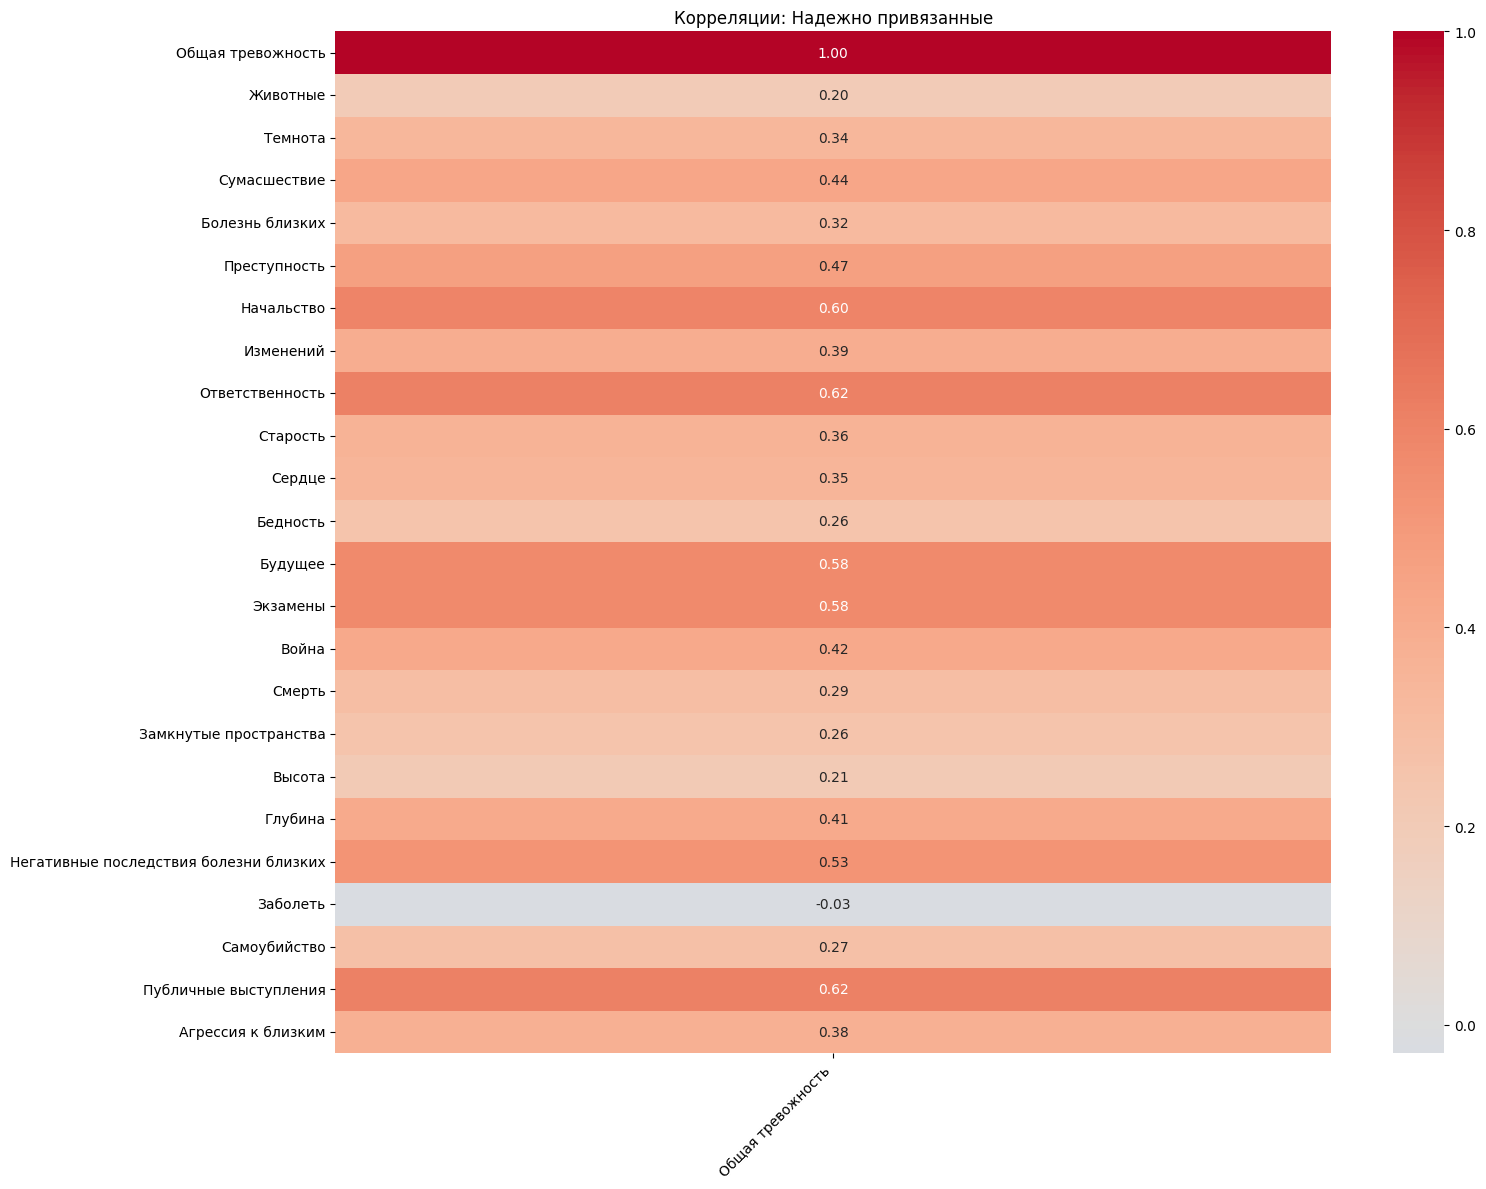

Heatmap для ненадежно привязанных:


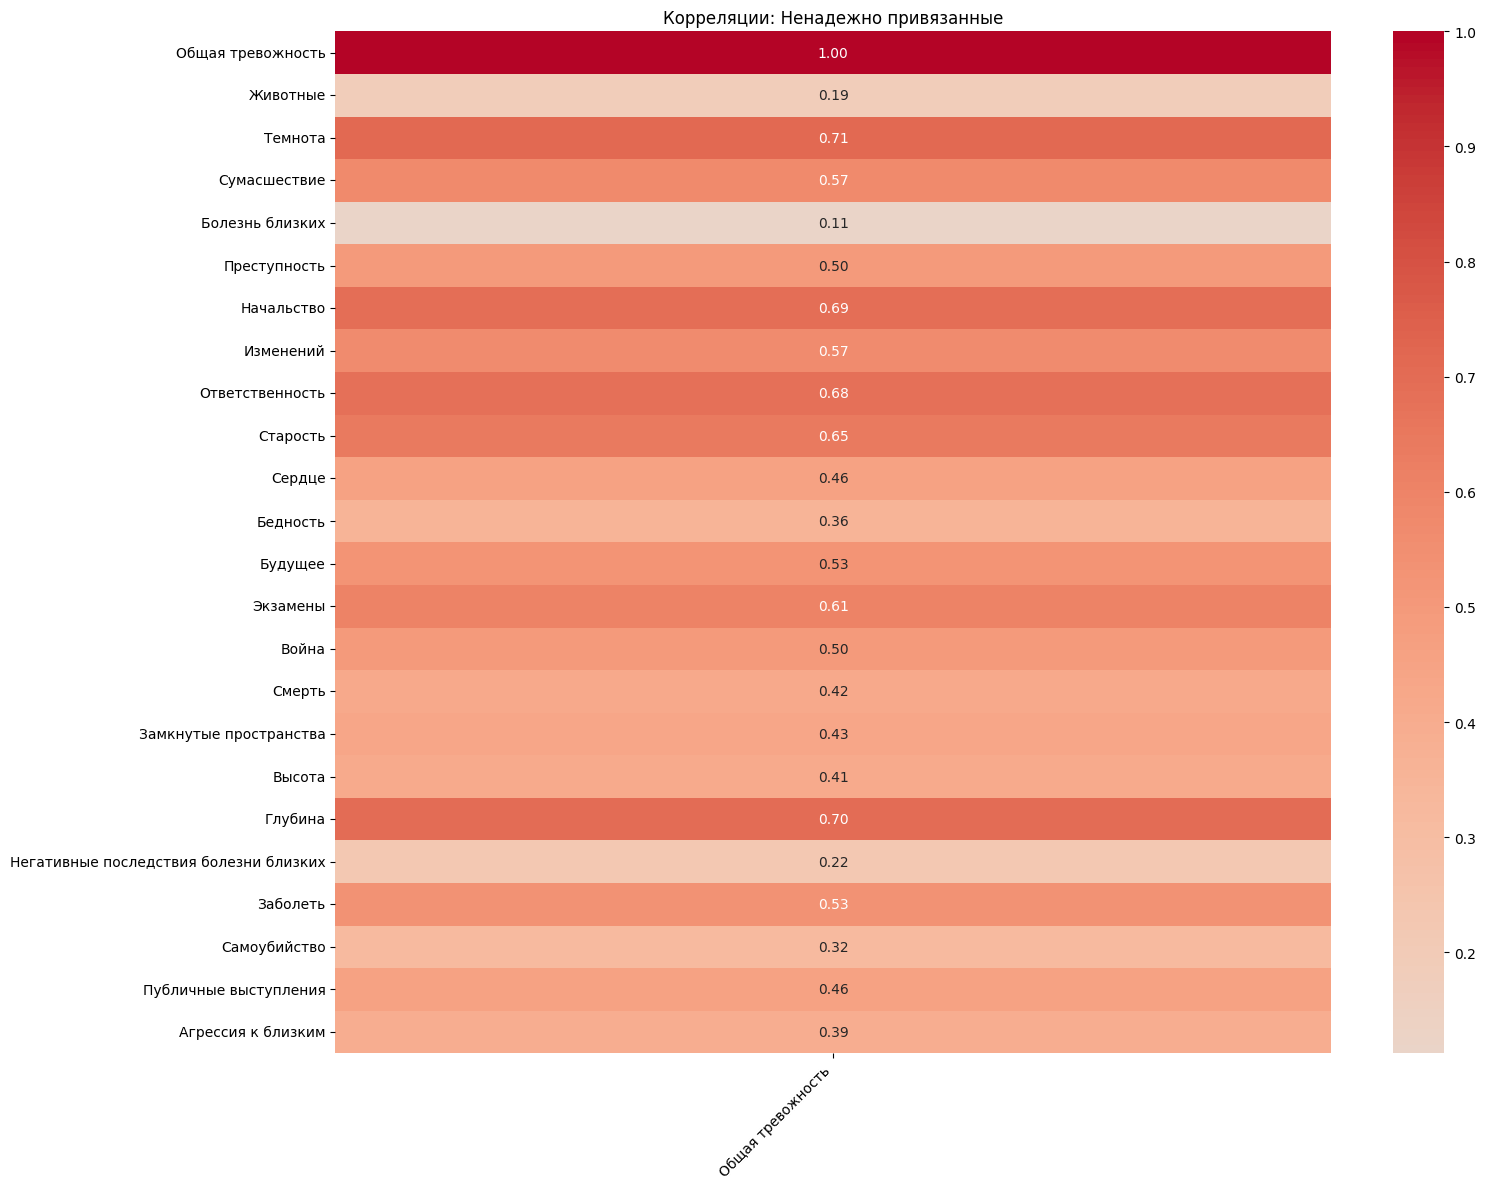

In [254]:
print("Heatmap для надежно привязанных:")
plot_correlation_heatmap(rel, "Корреляции: Надежно привязанные")

print("Heatmap для ненадежно привязанных:")
plot_correlation_heatmap(unrel, "Корреляции: Ненадежно привязанные")

Все обновления и историю изменений можно посмотреть по ссылке в моём репозитории \
https://github.com/matv864/AI_work/tree/main/matstat